In [2]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LinearSegmentedColormap
from enigmatoolbox.utils import parcel_to_surface
from nilearn import datasets, plotting
from nilearn.surface import load_surf_mesh

/home/tumnic/rbelenya/.conda/envs/pr_mcm/lib/python3.9/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# Make Schaefer color map

In [3]:
cmap = LinearSegmentedColormap.from_list(
    name='yeo_7nets',
    colors=[
        (0, (0, 0, 0)),
        (1/7, (120/256, 18/256, 134/256)),
        (2/7, (70/256, 130/256, 180/256)),
        (3/7, (0/256, 118/256, 14/256)),
        (4/7, (196/256, 58/256, 250/256)),
        (5/7, (220/256, 248/256, 164/256)),
        (6/7, (230/256, 148/256, 34/256)),
        (7/7, (205/256, 62/256, 78/256))
    ],
    N=8
)

# Load surface data and ROI info

In [4]:
fsaverage = datasets.fetch_surf_fsaverage()
rois_labels = pd.read_csv('./Schaefer2018_400_7N_order+regions.csv', sep=',')

schaefer_tex = parcel_to_surface(np.arange(401), 'schaefer_400_fsa5')
schaefer = {hemi:tex for hemi, tex in zip(['left', 'right'], np.split(schaefer_tex, 2))}

In [5]:
# Load coordinates and faces of fsaverage mesh
fs_mesh = {}
for hemi in ['left', 'right']:
    mesh = load_surf_mesh(fsaverage['infl_'+hemi])
    fs_mesh[hemi] = {'coords': mesh[0], 'faces': mesh[1]}

`fsaverage['pial_left/right']` or `fsaverage['infl_left/right']` are surface meshes - they contain coordinates of vertices (x,y,z) and faces (triangles) that are created by these coordintates  

In `fsaverage5` there are 10242 vertices. Some vertices can belong to 2 or 3 faces - so the number of faces is 20480

# Make Yeo 7 networks texture

In [19]:
nets = {net: i+1 for i, net in enumerate(rois_labels.net.unique())}
yeo_tex = np.zeros_like(schaefer_tex)
for i, roi in enumerate(schaefer_tex):
    if roi != 0:
        net, = rois_labels.loc[rois_labels.roi == roi, 'net'].values
        yeo_tex[i] = nets[net]
yeo = {hemi:tex for hemi, tex in zip(['left', 'right'], np.split(yeo_tex, 2))}

# Calculate centroid coordinates for every ROI

... or download a csv file from github repository and convert from RAS to xyz.  
Get all coordinates that belong to each ROI and find the average

In [21]:
centroids = {}
for hemi in ['left', 'right']:
    coords = fs_mesh[hemi]['coords']
    centers = pd.DataFrame(coords).assign(roi=schaefer[hemi]).groupby('roi').agg('mean')
    centers = centers.loc[centers.index != 0].reset_index() # remove the background roi
    roi, x, y, z = centers.T.to_numpy()
    centroids[hemi] = {'roi': roi, 'x': x, 'y': y, 'z': z}

# Make unit vectors

... from origin (0,0,0) in the direction where the "camera" is located. Different for each view 

In [22]:
povs = {
    'left': {
        'lateral': np.array([-1, 0, 0]),
        'medial': np.array([1, 0, 0]),
        'dorsal': np.array([0, 0, 1]),
        'ventral': np.array([0, 0, -1]),
        'anterior': np.array([0, 1, 0]),
        'posterior': np.array([0, -1, 0])
    },
    'right': {
        'lateral': np.array([1, 0, 0]),
        'medial': np.array([-1, 0, 0]),
        'dorsal': np.array([0, 0, 1]),
        'ventral': np.array([0, 0, -1]),
        'anterior': np.array([0, 1, 0]),
        'posterior': np.array([0, -1, 0])
    }
}

# Find vectors perpendicular to faces

for each face
1. get the face's coordinates
2. find two vectors in the plane of that face
3. find the cross-product o fthese two direction vectors

Then, for each ROI take average of all vectors perpendicular to that ROI's faces 

In [23]:
def roi_norm(coords, faces):
    
    face_vs = [] # normal vector for each face
    face_rois = [] # roi to which that face belongs

    for i, j, k in faces:
        
        p1, p2, p3 = coords[i, :], coords[j, :], coords[k, :] # points that define the face
        p12 = p2 - p1 # direction vector from point 1 to point 2
        p13 = p3 - p1
        
        v = np.cross(p12, p13) # perpendicular to two vectors -> perpendicular to the face
        face_vs.append(v / np.linalg.norm(v)) 

        roi1 = schaefer[hemi][np.where(p1 == coords)[0][0]]
        roi2 = schaefer[hemi][np.where(p2 == coords)[0][0]]
        roi3 = schaefer[hemi][np.where(p3 == coords)[0][0]]
        
        # find most occuring roi - not very accurate: a point can belong to three rois
        face_rois.append(stats.mode([roi1, roi2, roi3])[0][0])

    df = pd.DataFrame(face_vs).assign(roi=face_rois).groupby('roi').agg('mean')
    df = df.loc[df.index != 0].reset_index()
    
    return(df.to_numpy())

In [24]:
# Norms dict contains an average perpendicular vector to each ROI
norms = {}

for hemi in ['left', 'right']:
    data = roi_norm(fs_mesh[hemi]['coords'], fs_mesh[hemi]['faces'])
    roi, x, y, z = data.T
    norms[hemi] = {'roi': roi, 'v': np.array([x, y, z]).T}

# Calculate the angles

... between average perpenducular vectors of each ROI and the "view" vector. Idea is that ROIs on the other side of the brain from a certain point of view should have angles larger than 90$^\circ$

In [25]:
angles = {}

for hemi in ['left', 'right']:
    angles[hemi] = {}
    for view in ['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']:
        pov = povs[hemi][view]
        norm = norms[hemi]['v']
        
        ang = np.arccos(np.dot(norm, pov).flatten() / ( np.linalg.norm(norm, axis=1) * np.linalg.norm(pov) ))
        ang = np.degrees(ang)
        
        angles[hemi][view] = ang

# Visualize the perpendicular vectors

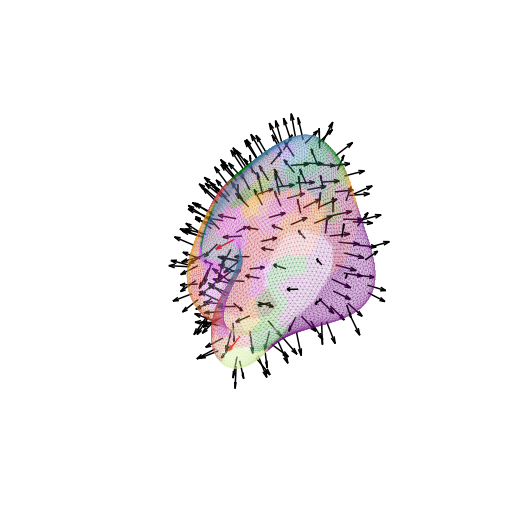

In [26]:
hemi = 'left'
view = 'lateral'

figure = plt.figure(figsize=[7,7])
axes = figure.add_axes((0,0,1,1), projection="3d")

plotting.plot_surf_roi(fsaverage['infl_'+hemi], yeo[hemi], hemi=hemi, cmap=cmap,
                       bg_map=fsaverage['sulc_'+hemi], darkness=0.1, alpha=0.1,
                        view=view, bg_on_data=True, figure=figure, axes=axes);

roi, x, y, z = centroids[hemi].values()
visible = angles[hemi][view] <= 90
vectors = norms[hemi]['v']

for roi, x, y, z, visible, vec in zip(roi, x, y, z, visible, vectors):
    if np.isin(roi, [92, 151]):
        color='r'
    else:
        color='k'
        
    axes.quiver(x, y, z, vec[0], vec[1], vec[2], length=15, color=color)
        
pov = povs[hemi][view]
axes.view_init(0, 240)

# Make brain figures  
Does not work so well for dorsal/ventral, anterior/posterior bc of weird angles

/tmp/ipykernel_20095/1927226928.py:26: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  figure.savefig(hemi + '-' + view + '.png', dpi=600, transparent=True)
/home/tumnic/rbelenya/.conda/envs/pr_mcm/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


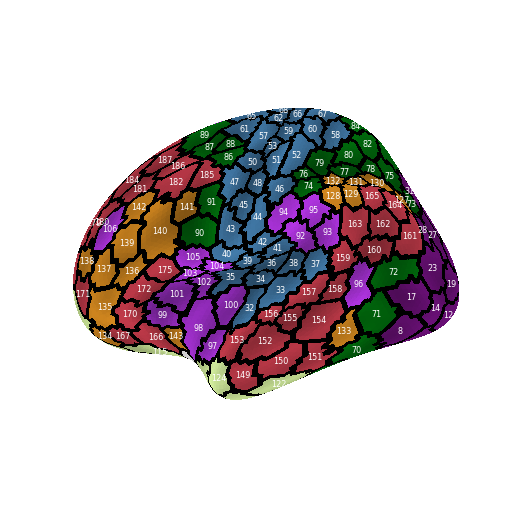

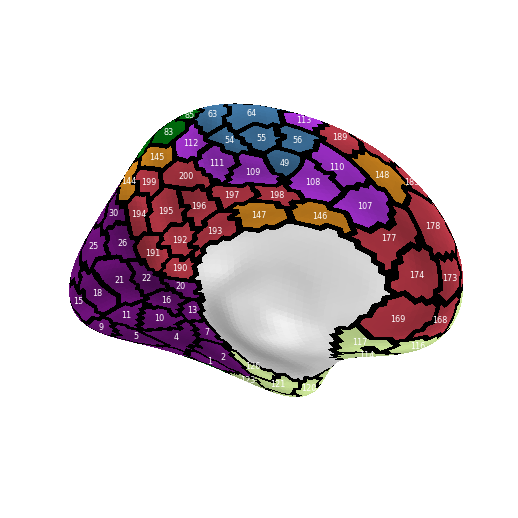

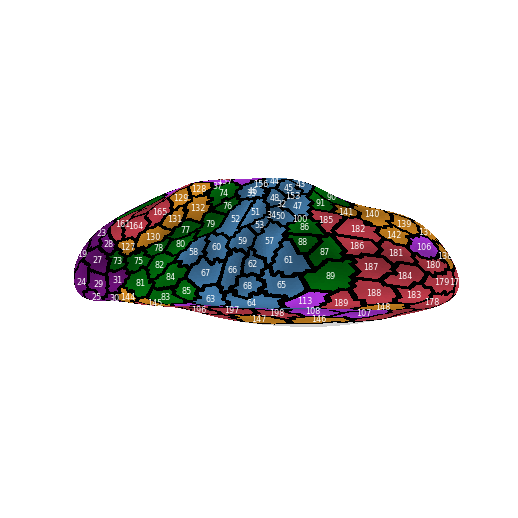

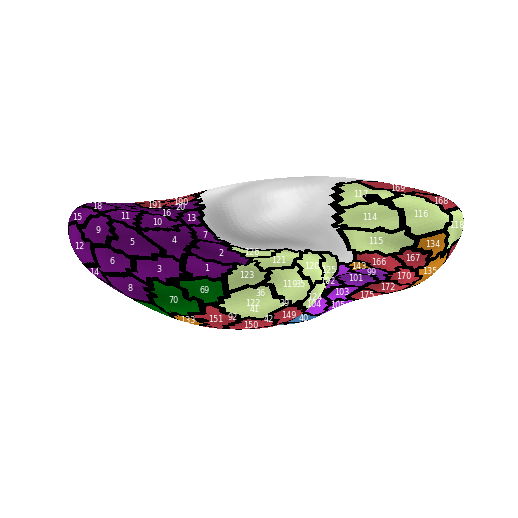

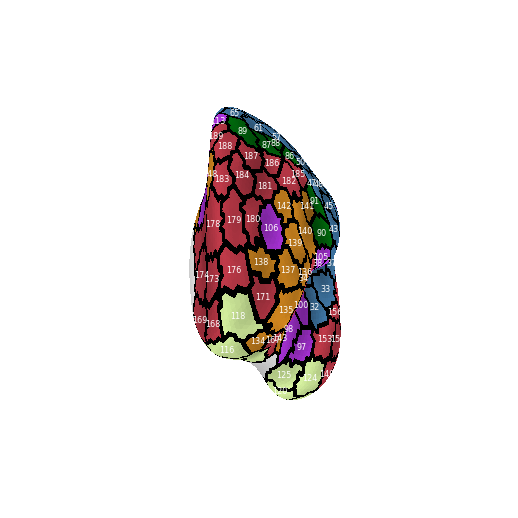

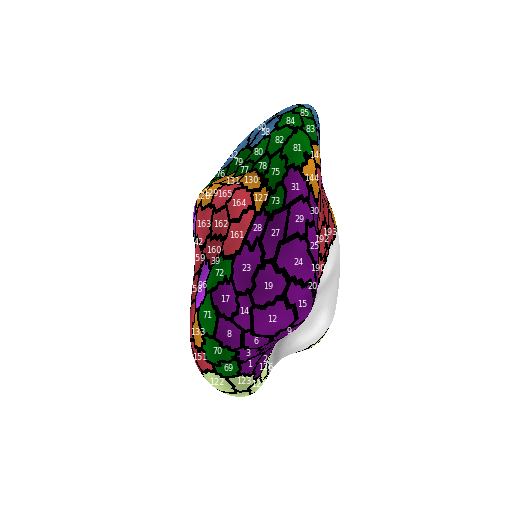

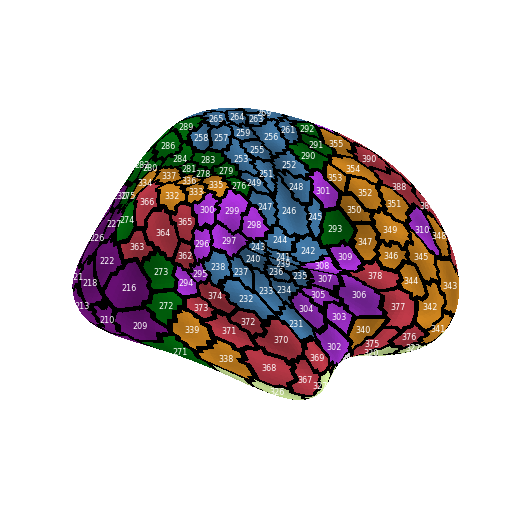

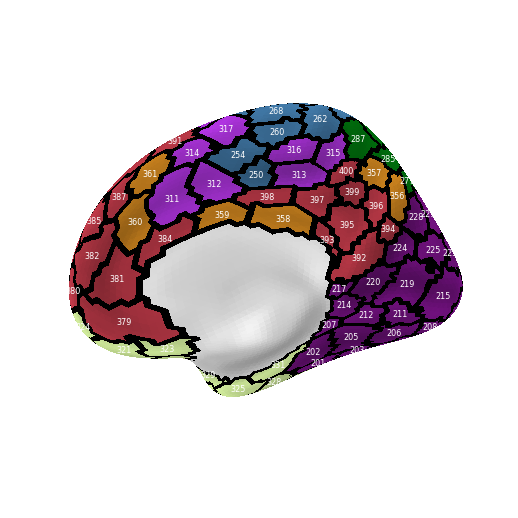

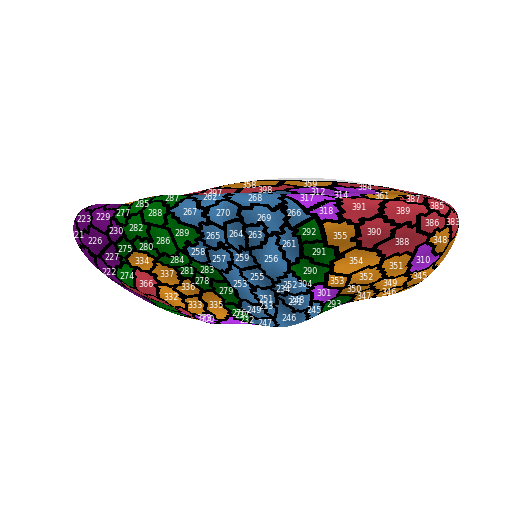

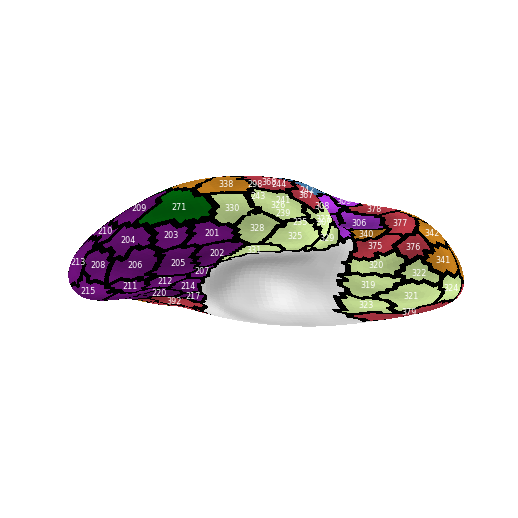

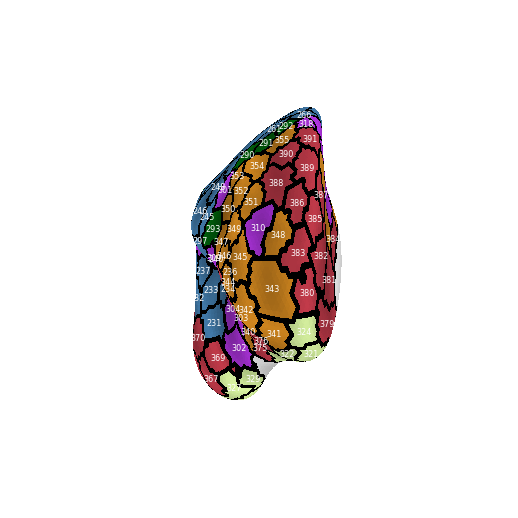

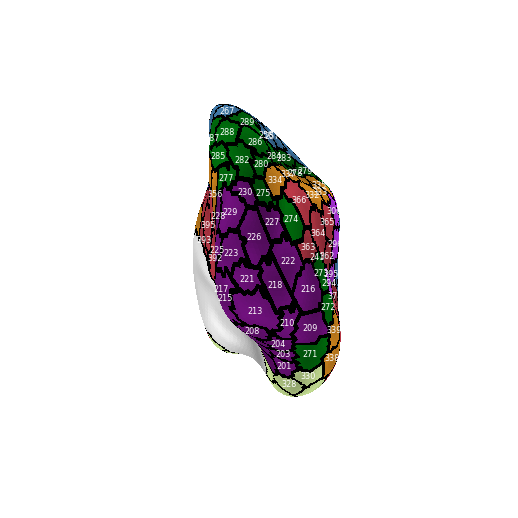

In [32]:
for hemi in ['left', 'right']:
    for view in ['lateral', 'medial', 'dorsal', 'ventral', 'anterior', 'posterior']:
        
        figure = plt.figure(figsize=[7,7], constrained_layout=True)
        axes = figure.add_axes((0,0,1,1), projection="3d")
        
        plotting.plot_surf_roi(fsaverage['infl_'+hemi], yeo[hemi], hemi=hemi,
                               bg_map=fsaverage['sulc_'+hemi], cmap=cmap, darkness=0.5,
                                view=view, bg_on_data=True, figure=figure, axes=axes);
        
        plotting.plot_surf_contours(fsaverage['infl_'+hemi], schaefer[hemi],
                                    colors=['k']*201, figure=figure, axes=axes);
            
        roi, x, y, z = centroids[hemi].values()
        visible = angles[hemi][view] <= 80
        vectors = norms[hemi]['v']
        
        for roi, x, y, z, visible in zip(roi, x, y, z, visible):
            if visible:
                roi = int(roi)
                axes.text(x, y, z, roi, color='white', fontsize=8,
                          verticalalignment='center', horizontalalignment='center',
                          multialignment='center', in_layout=True)
                
#         axes.set_title(hemi + ' ' + view)
        figure.savefig(hemi + '-' + view + '.png', dpi=600, transparent=True)